In [117]:
# import neccessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px

In [119]:
# Configuration
PRIMARY_TICKER = "MSFT"
PAIR_TICKER = 'WMT'
TICKERS = [PRIMARY_TICKER, PAIR_TICKER]
PERIOD = '2y'
INTERVAL = '1d'
WINDOW = 5

### Step 1: Data Collection & Exploration
Download the data using Yahoo Finance and display the first and last few rows.

In [122]:
def get_data(primary_ticker, pair_ticker, period, interval):
    """
    Downloads historical closing prices for the given tickers.
    Returns a DataFrame of prices and a DataFrame of daily percentage returns.
    """
    data = yf.download([primary_ticker, pair_ticker], period=period, interval=interval)['Close']
    returns = data.pct_change().dropna()
    return data, returns

# Run data collection:
data, returns = get_data(PRIMARY_TICKER, PAIR_TICKER, PERIOD, INTERVAL)

# Explore the data:
print("==== DATA HEAD ====")
print(data.head())
print("\n==== DATA TAIL ====")
print(data.tail())


[*********************100%***********************]  2 of 2 completed


==== DATA HEAD ====
Ticker            MSFT        WMT
Date                             
2023-08-01  331.190125  51.761963
2023-08-02  322.485504  51.797745
2023-08-03  321.658417  51.810764
2023-08-04  322.761169  51.511459
2023-08-07  325.055481  52.210899

==== DATA TAIL ====
Ticker            MSFT        WMT
Date                             
2025-07-28  512.500000  97.610001
2025-07-29  512.570007  98.330002
2025-07-30  513.239990  97.589996
2025-07-31  533.500000  97.980003
2025-08-01  522.950012  98.120003


### Step 2: Visualize Daily % Returns (Plotly)
Plot the daily percentage returns for the primary and pair tickers.

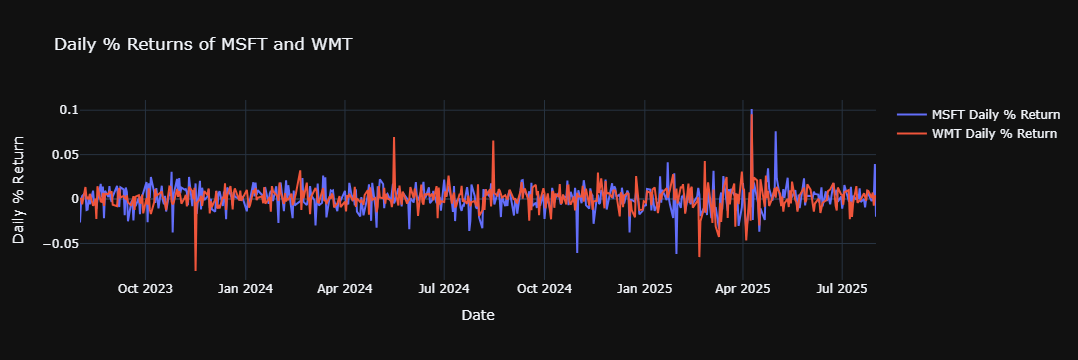

In [124]:
def plot_daily_returns(returns, primary_ticker, pair_ticker):
    """
    Plots daily percentage returns of the two tickers using Plotly.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=returns.index, y=returns[primary_ticker],
                             mode='lines', name=f'{primary_ticker} Daily % Return'))
    fig.add_trace(go.Scatter(x=returns.index, y=returns[pair_ticker],
                             mode='lines', name=f'{pair_ticker} Daily % Return'))
    fig.update_layout(title=f"Daily % Returns of {primary_ticker} and {pair_ticker}",
                      xaxis_title="Date", yaxis_title="Daily % Return",
                      template="plotly_dark")
    fig.show()

# Run the visualization:
plot_daily_returns(returns, PRIMARY_TICKER, PAIR_TICKER)


### Step 3: Mean-Reversion Strategy & Parameter Sweep
Test a fine grid of z‑score thresholds (from 0.02 to 3.0 in increments of 0.01) and display the top results (best performing z‑scores).

Make sure you have defined the mean‑reversion function:

In [128]:
def mean_reversion_strategy_returns(data, returns, primary_ticker, pair_ticker, window, z_threshold):
    """
    Computes the mean-reversion strategy daily returns.
    Long signal: primary ticker’s z-score < -z_threshold.
    Short signal: primary ticker’s z-score > z_threshold.
    The pair ticker takes the inverse position.
    """
    # Calculate rolling mean and standard deviation on prices:
    rolling_mean = data.rolling(window).mean()
    rolling_std = data.rolling(window).std()
    zscore = (data - rolling_mean) / rolling_std

    # Generate signals for the primary ticker:
    long_signal = zscore[primary_ticker] < -z_threshold
    short_signal = zscore[primary_ticker] > z_threshold

    # Create positions: +1 for long, -1 for short; pair ticker is inverse:
    positions = pd.DataFrame(index=data.index)
    positions[primary_ticker] = np.where(long_signal, 1, np.where(short_signal, -1, 0))
    positions[pair_ticker] = -positions[primary_ticker]

    # Calculate daily strategy returns (shift positions to avoid lookahead bias):
    strat_returns = (positions.shift(1) * returns).sum(axis=1)
    return strat_returns.dropna()


In [130]:
def parameter_sweep(data, returns, primary_ticker, pair_ticker, window, z_values):
    """
    Sweeps over a range of z_threshold values.
    For each value, computes the final cumulative return of the strategy.
    Returns a DataFrame sorted in descending order by cumulative return.
    """
    results = []
    for z in z_values:
        daily_returns = mean_reversion_strategy_returns(data, returns, primary_ticker, pair_ticker, window, z)
        cumulative_return = (1 + daily_returns).cumprod().iloc[-1]
        results.append({'z_threshold': z, 'final_cumulative_return': cumulative_return})
    
    results_df = pd.DataFrame(results)
    # Sort by final cumulative return in descending order
    results_df_sorted = results_df.sort_values(by='final_cumulative_return', ascending=False)
    return results_df_sorted

# Generate z_threshold values from 0.02 to 3.0 in increments of 0.01
z_values = np.arange(0.02, 3.01, 0.01)

# Run the parameter sweep
sweep_results = parameter_sweep(data, returns, PRIMARY_TICKER, PAIR_TICKER, WINDOW, z_values)

# Print the top rows (best performing z-scores)
print("Top parameter sweep results (best performing z-scores):")
print(sweep_results.head())


Top parameter sweep results (best performing z-scores):
    z_threshold  final_cumulative_return
73         0.75                 1.678701
71         0.73                 1.657336
70         0.72                 1.652011
74         0.76                 1.638762
68         0.70                 1.636864


### Step 4: Optimal Strategy – Cumulative Returns Plot (Plotly)
Select the optimal z‑score (with the highest cumulative return) and plot the strategy’s cumulative returns.

Optimal z_threshold selected: 0.7499999999999999


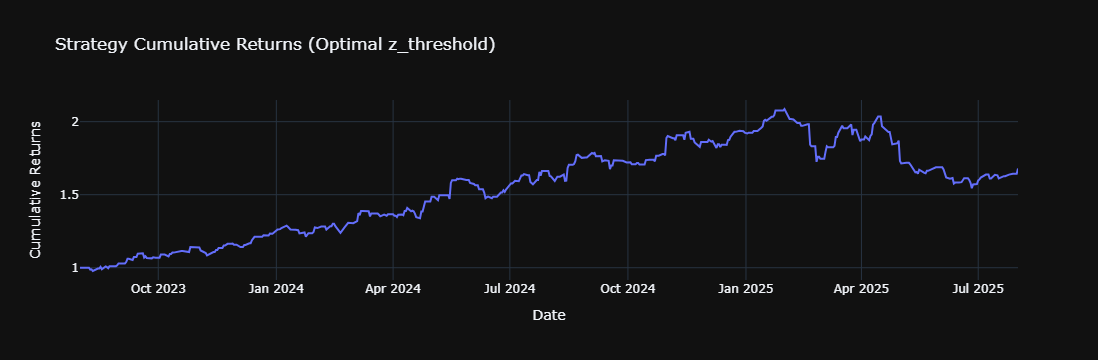

In [132]:
def plot_strategy_cumulative_returns(daily_returns):
    """
    Plots the cumulative returns of the strategy using Plotly.
    """
    cumulative = (1 + daily_returns).cumprod()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cumulative.index, y=cumulative, mode='lines',
                             name='Cumulative Returns'))
    fig.update_layout(title="Strategy Cumulative Returns (Optimal z_threshold)",
                      xaxis_title="Date", yaxis_title="Cumulative Returns",
                      template="plotly_dark")
    fig.show()

# Determine the optimal z_threshold from the sweep results (results are sorted descending)
best_row = sweep_results.iloc[0]
best_z = best_row['z_threshold']
print(f"Optimal z_threshold selected: {best_z}")

# Compute the optimal daily strategy returns using the best z_threshold
optimal_daily_returns = mean_reversion_strategy_returns(data, returns, PRIMARY_TICKER, PAIR_TICKER, WINDOW, best_z)

# Plot the cumulative returns of the strategy with the optimal z_threshold
plot_strategy_cumulative_returns(optimal_daily_returns)


### Step 5: Monte Carlo Simulation & Histogram (Plotly)
Perform a Monte Carlo simulation (bootstrapping) on the optimal strategy returns and display a histogram of final cumulative returns.

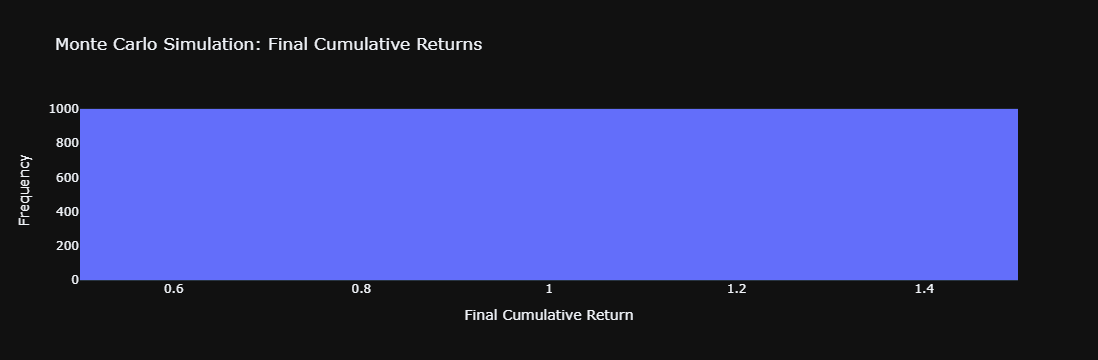

In [112]:
def monte_carlo_bootstrap(strategy_returns, num_simulations=1000, seed=42):
    """
    Performs a Monte Carlo simulation by bootstrapping the strategy returns.
    Returns an array of final cumulative returns from each simulation.
    """
    np.random.seed(seed)
    n_days = len(strategy_returns)
    final_values = []
    for _ in range(num_simulations):
        sampled = strategy_returns.sample(n=n_days, replace=True)
        final_cumulative = (1 + sampled).cumprod().iloc[-1]
        final_values.append(final_cumulative)
    return final_values

def plot_monte_carlo_histogram(final_values):
    """
    Plots a histogram of the final cumulative returns from the Monte Carlo simulation using Plotly.
    """
    fig = px.histogram(x=final_values, nbins=60, title="Monte Carlo Simulation: Final Cumulative Returns")
    fig.update_layout(xaxis_title="Final Cumulative Return", yaxis_title="Frequency",
                      template="plotly_dark")
    fig.show()

# Run the Monte Carlo simulation on the optimal strategy returns
mc_final_values = monte_carlo_bootstrap(optimal_daily_returns, num_simulations=1000, seed=42)
plot_monte_carlo_histogram(mc_final_values)
